In [2]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine

user = 'root'
password = 'minjegal0408!'
host = 'localhost'
port = 3306
database = 'interest_db'

engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')


knowledge = pd.read_sql('SELECT * FROM knowledge', engine)
skills = pd.read_sql('SELECT * FROM skills', engine)
abilities = pd.read_sql('SELECT * FROM abilities', engine)
interest = pd.read_sql('SELECT * FROM interests', engine)
occupation = pd.read_sql('SELECT * FROM occupation_data', engine)
content_ref = pd.read_sql('SELECT * FROM content_model_reference', engine)


In [3]:
occupation = pd.read_sql('SELECT * FROM occupation_data', engine)
occupation_sub = occupation.drop(columns=['description'])
occupation_sub.head(0)

occupation_sub.to_csv('occupation.csv')


In [4]:
print(knowledge.head(2))
print(skills.head(2))
print(abilities.head(2))
print(interest.head(2))
print(occupation.head(2))


  onetsoc_code element_id scale_id  data_value     n  standard_error  \
0   11-1011.00    2.C.1.a       IM        4.78  28.0          0.1102   
1   11-1011.00    2.C.1.a       LV        6.50  28.0          0.2130   

   lower_ci_bound  upper_ci_bound recommend_suppress not_relevant  \
0          4.5564          5.0000                  N         None   
1          6.0666          6.9409                  N            N   

  date_updated domain_source  
0   2023-08-01     Incumbent  
1   2023-08-01     Incumbent  
  onetsoc_code element_id scale_id  data_value    n  standard_error  \
0   11-1011.00    2.A.1.a       IM        4.12  8.0           0.125   
1   11-1011.00    2.A.1.a       LV        4.62  8.0           0.183   

   lower_ci_bound  upper_ci_bound recommend_suppress not_relevant  \
0          3.8800          4.3700                  N         None   
1          4.2664          4.9836                  N            N   

  date_updated domain_source  
0   2023-08-01       Analyst 

In [5]:
def optimize_df(df):
    df['onetsoc_code'] = df['onetsoc_code'].astype('category')
    df['element_id'] = df['element_id'].astype('category')
    df['scale_id'] = df['scale_id'].astype('category')
    df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce', downcast='float')
    return df
knowledge = optimize_df(knowledge)
skills = optimize_df(skills)
abilities = optimize_df(abilities)
interest = optimize_df(interest)
occupation['onetsoc_code'] = occupation['onetsoc_code'].astype('category')

In [6]:
print(interest.head())

  onetsoc_code element_id scale_id  data_value date_updated     domain_source
0   11-1011.00    1.B.1.a       OI        1.30   2023-11-01  Machine Learning
1   11-1011.00    1.B.1.b       OI        3.24   2023-11-01  Machine Learning
2   11-1011.00    1.B.1.c       OI        2.08   2023-11-01  Machine Learning
3   11-1011.00    1.B.1.d       OI        3.52   2023-11-01  Machine Learning
4   11-1011.00    1.B.1.e       OI        6.88   2023-11-01  Machine Learning


In [7]:
def selectAndFilter(df, is_interest=False):
    df_sub = df[['onetsoc_code', 'element_id', 'scale_id', 'data_value']]
    if not is_interest:
        df_sub = df_sub[df_sub['scale_id'] == 'IM']
    return df_sub

knowledge_sub = selectAndFilter(knowledge)
skills_sub = selectAndFilter(skills)
abilities_sub = selectAndFilter(abilities)
interest_sub = selectAndFilter(interest, True)

In [8]:
element_mapping = content_ref.set_index('element_id')['element_name'].to_dict()
interest_sub['element_id'] = interest_sub['element_id'].map(element_mapping)
print(interest_sub.head())


knowledge_sub['element_id'] = knowledge_sub['element_id'].map(element_mapping)
skills_sub['element_id'] = skills_sub['element_id'].map(element_mapping)
abilities_sub['element_id'] = abilities_sub['element_id'].map(element_mapping)
print(knowledge_sub.head())

  onetsoc_code     element_id scale_id  data_value
0   11-1011.00      Realistic       OI        1.30
1   11-1011.00  Investigative       OI        3.24
2   11-1011.00       Artistic       OI        2.08
3   11-1011.00         Social       OI        3.52
4   11-1011.00   Enterprising       OI        6.88
  onetsoc_code                     element_id scale_id  data_value
0   11-1011.00  Administration and Management       IM        4.78
2   11-1011.00                 Administrative       IM        2.42
4   11-1011.00       Economics and Accounting       IM        4.04
6   11-1011.00            Sales and Marketing       IM        3.81
8   11-1011.00  Customer and Personal Service       IM        4.39


C:\Users\min\AppData\Local\Temp\ipykernel_2892\3184942682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interest_sub['element_id'] = interest_sub['element_id'].map(element_mapping)


In [9]:
exclude_elements = ['First Interest High-Point', 'Second Interest High-Point', 'Third Interest High-Point']
interest_sub = interest_sub[~interest_sub['element_id'].isin(exclude_elements)]

print(interest_sub)


     onetsoc_code     element_id scale_id  data_value
0      11-1011.00      Realistic       OI        1.30
1      11-1011.00  Investigative       OI        3.24
2      11-1011.00       Artistic       OI        2.08
3      11-1011.00         Social       OI        3.52
4      11-1011.00   Enterprising       OI        6.88
...           ...            ...      ...         ...
8299   53-7121.00  Investigative       OI        1.94
8300   53-7121.00       Artistic       OI        1.00
8301   53-7121.00         Social       OI        1.00
8302   53-7121.00   Enterprising       OI        1.31
8303   53-7121.00   Conventional       OI        4.68

[5538 rows x 4 columns]


In [10]:
def pivot_df(df,prefix):
    df_pivot = df.pivot_table(
        index = 'onetsoc_code',
        columns = 'element_id',
        values = 'data_value',
        aggfunc = 'mean'
    )

    df_pivot.columns = [f"{prefix}_{str(col)}" for col in df_pivot.columns]
    return df_pivot

knowledge_pivot = pivot_df(knowledge_sub, 'knowledge')
skills_pivot = pivot_df(skills_sub, 'skills')
abilities_pivot = pivot_df(abilities_sub, 'abilities')
interest_pivot = pivot_df(interest_sub, 'interest')

print(interest_pivot.head())

              interest_Realistic  interest_Investigative  interest_Artistic  \
onetsoc_code                                                                  
11-1011.00                  1.30                    3.24               2.08   
11-1011.03                  2.04                    4.78               2.48   
11-1021.00                  2.22                    2.39               1.31   
11-1031.00                  1.54                    3.35               2.70   
11-2011.00                  1.07                    1.71               3.85   

              interest_Social  interest_Enterprising  interest_Conventional  
onetsoc_code                                                                 
11-1011.00               3.52                   6.88                   5.00  
11-1011.03               3.55                   6.68                   4.49  
11-1021.00               3.37                   6.96                   5.32  
11-1031.00               3.69                   5.52    

In [11]:
print("Number of occupations in knowledge_pivot:", knowledge_pivot.shape[0])
print("Number of occupations in skills_pivot:", skills_pivot.shape[0])
print("Number of occupations in abilities_pivot:", abilities_pivot.shape[0])
print("Number of occupations in interest_pivot:", interest_pivot.shape[0])
print("Number of occupations in occupation dataframe:", occupation['onetsoc_code'].nunique())

print("SHAPE OF knowledge_pivot:", knowledge_pivot.shape)
print("SHAPE OF skills_pivot:", skills_pivot.shape)
print("SHAPE OF  abilities_pivot:", abilities_pivot.shape)
print("SHAPE OF  interest_pivot:", interest_pivot.shape)
print("SHAPE OF  occupation dataframe:", occupation['onetsoc_code'].nunique())


Number of occupations in knowledge_pivot: 873
Number of occupations in skills_pivot: 873
Number of occupations in abilities_pivot: 873
Number of occupations in interest_pivot: 923
Number of occupations in occupation dataframe: 1016
SHAPE OF knowledge_pivot: (873, 33)
SHAPE OF skills_pivot: (873, 35)
SHAPE OF  abilities_pivot: (873, 52)
SHAPE OF  interest_pivot: (923, 6)
SHAPE OF  occupation dataframe: 1016


In [12]:
print(f"interest:{interest_pivot.head(5)}")
print(f"knowledge: {knowledge_pivot.head(5)}")
print(f"abilities: {abilities_pivot.head(5)}")
print(skills_pivot.head(5))




interest:              interest_Realistic  interest_Investigative  interest_Artistic  \
onetsoc_code                                                                  
11-1011.00                  1.30                    3.24               2.08   
11-1011.03                  2.04                    4.78               2.48   
11-1021.00                  2.22                    2.39               1.31   
11-1031.00                  1.54                    3.35               2.70   
11-2011.00                  1.07                    1.71               3.85   

              interest_Social  interest_Enterprising  interest_Conventional  
onetsoc_code                                                                 
11-1011.00               3.52                   6.88                   5.00  
11-1011.03               3.55                   6.68                   4.49  
11-1021.00               3.37                   6.96                   5.32  
11-1031.00               3.69                  

In [13]:
from functools import reduce

pivot_dfs = [knowledge_pivot,skills_pivot,abilities_pivot, interest_pivot]

agg_df = reduce(
    lambda left, right: pd.merge(left, right, on ='onetsoc_code', how ='inner'),
    pivot_dfs
)

agg_df = pd.merge(occupation[['onetsoc_code']], agg_df, on = 'onetsoc_code', how ='inner')

print("Aggregated DataFrame Shape:", agg_df.shape)
print(agg_df.head())

Aggregated DataFrame Shape: (873, 127)
  onetsoc_code  knowledge_Administration and Management  \
0   11-1011.00                                     4.78   
1   11-1011.03                                     4.15   
2   11-1021.00                                     4.25   
3   11-2011.00                                     4.12   
4   11-2021.00                                     4.04   

   knowledge_Administrative  knowledge_Economics and Accounting  \
0                      2.42                                4.04   
1                      2.62                                3.19   
2                      3.21                                3.20   
3                      3.25                                3.04   
4                      3.01                                3.10   

   knowledge_Sales and Marketing  knowledge_Customer and Personal Service  \
0                           3.81                                     4.39   
1                           3.15                 

In [14]:
print("Statistical Summary:")
print(agg_df.describe())

Statistical Summary:
       knowledge_Administration and Management  knowledge_Administrative  \
count                               873.000000                873.000000   
mean                                  3.018545                  2.702852   
std                                   0.579691                  0.635902   
min                                   1.540000                  1.090000   
25%                                   2.620000                  2.250000   
50%                                   2.980000                  2.690000   
75%                                   3.390000                  3.120000   
max                                   4.780000                  4.810000   

       knowledge_Economics and Accounting  knowledge_Sales and Marketing  \
count                          873.000000                     873.000000   
mean                             2.158007                       2.188992   
std                              0.654447                       0.

In [15]:
print("Missing values per column:")
print(agg_df.isnull().sum())

Missing values per column:
onetsoc_code                               0
knowledge_Administration and Management    0
knowledge_Administrative                   0
knowledge_Economics and Accounting         0
knowledge_Sales and Marketing              0
                                          ..
interest_Investigative                     0
interest_Artistic                          0
interest_Social                            0
interest_Enterprising                      0
interest_Conventional                      0
Length: 127, dtype: int64


In [16]:
# Ensure that 'features' is a DataFrame containing your feature columns
features = agg_df.drop('onetsoc_code', axis=1)  # Drop the onetsoc_code column from the features

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_f = scaler.fit_transform(features)

# Create a DataFrame for the scaled features
agg_df_scaled = pd.DataFrame(scaled_f, columns=features.columns)

# Add the 'onetsoc_code' column back to the scaled DataFrame
agg_df_scaled['onetsoc_code'] = agg_df['onetsoc_code']

# Output the head of the scaled DataFrame
print("Scaled DataFrame:")
print(agg_df_scaled.head())

# Save the scaled DataFrame for later use
agg_df_scaled.to_csv('agg_df_scaled.csv', index=False)



Scaled DataFrame:
   knowledge_Administration and Management  knowledge_Administrative  \
0                                 3.040354                 -0.445059   
1                                 1.952944                 -0.130366   
2                                 2.125549                  0.797982   
3                                 1.901163                  0.860921   
4                                 1.763079                  0.483288   

   knowledge_Economics and Accounting  knowledge_Sales and Marketing  \
0                            2.877348                       2.184572   
1                            1.577797                       1.295115   
2                            1.593086                       1.079488   
3                            1.348465                       3.357038   
4                            1.440198                       3.586140   

   knowledge_Customer and Personal Service  \
0                                 1.225926   
1                       

# Data Prep for Rec SYS


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

occupation_df = pd.read_csv('occupation.csv')
occupation_df.set_index('onetsoc_code', inplace=True)

print("occupation mapping")
print(occupation_df.head(5))

occupation mapping
              Unnamed: 0                                title
onetsoc_code                                                 
11-1011.00             0                     Chief Executives
11-1011.03             1        Chief Sustainability Officers
11-1021.00             2      General and Operations Managers
11-1031.00             3                          Legislators
11-2011.00             4  Advertising and Promotions Managers


In [23]:
riasec_features = [
    'interest_Realistic',
    'interest_Investigative',
    'interest_Artistic',
    'interest_Social',
    'interest_Enterprising',
    'interest_Conventional'
]

knowledge_f = [col for col in agg_df_scaled.columns if col.startswith('knowledge_')]
abilities_f = [col for col in agg_df_scaled.columns if col.startswith('abilities_')]
skills_f = [col for col in agg_df_scaled.columns if col.startswith('skills_')]


def extract_f(row, feature_columns, prefix):
    features = {}
    for col in feature_columns:
        if row[col] > 0:
            feature_name = col.replace(prefix,'')
            features[feature_name] = row[col]
    return features

In [33]:
occupation_df['title']

onetsoc_code
11-1011.00                                     Chief Executives
11-1011.03                        Chief Sustainability Officers
11-1021.00                      General and Operations Managers
11-1031.00                                          Legislators
11-2011.00                  Advertising and Promotions Managers
                                    ...                        
55-3014.00                   Artillery and Missile Crew Members
55-3015.00               Command and Control Center Specialists
55-3016.00                                             Infantry
55-3018.00                                       Special Forces
55-3019.00    Military Enlisted Tactical Operations and Air/...
Name: title, Length: 1016, dtype: object

# Recommendation Function
### - Collaborative Filltering


1) Weighting Aggregated Scores by Similarity:
* Purpose: Ensure that occupations with higher similarity scores contribute more significantly to the aggregated feature scores.
* Implementation: Multiply each feature's importance score by the occupation's similarity score before aggregation.

2) Applying Thresholds:
* Purpose: Exclude features with low aggregated scores that may not be as relevant.
* Implementation: Set minimum score thresholds for inclusion in the final recommendations.


3) Normalizing Aggregated Scores:
* Purpose: Maintain consistency in the scale of aggregated scores, especially after weighting.
* Implementation: Use normalization techniques (e.g., Min-Max Scaling) to scale the aggregated scores.

In [46]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def extract_features(row, feature_columns, prefix, clean=True):
    features = {}
    for col in feature_columns:
        if row[col] > 0:  # Include only features with positive importance
            feature_name = col.replace(prefix, '')
            if clean:
                feature_name = feature_name.replace('_', ' ').title()
            features[feature_name] = row[col]
    return features

def recommend_career(
    user_profile, 
    agg_df_scaled, 
    occupation_df, 
    riasec_features, 
    knowledge_features, 
    abilities_features, 
    skills_features, 
    top_n=5, 
    top_skills=10, 
    top_abilities=10, 
    top_knowledge=10,
    min_skill_score=0.5, 
    min_ability_score=0.5, 
    min_knowledge_score=0.5
):
    
    user_df = pd.DataFrame([user_profile])
    
    for feature in riasec_features:
        if feature not in user_df.columns:
            user_df[feature] = 0.0
    
    user_df = user_df[riasec_features]
    user_vector = user_df.values
    similarities = cosine_similarity(user_vector, agg_df_scaled[riasec_features].values)[0] # Compute cosine similarity between user and all jobs
    
    agg_df_scaled = agg_df_scaled.copy()
    agg_df_scaled['similarity'] = similarities
  
    top_jobs = agg_df_scaled.sort_values(by='similarity', ascending=False).head(top_n) # Sort jobs by similarity in descending order and select top N
    top_jobs = top_jobs.merge(occupation_df[['title']], on='onetsoc_code', how='left')
    
    recommendations = [] # Extract Skills, Abilities, Knowledge Areas for top occupations
    for _, row in top_jobs.iterrows(): 
        job = {
            'onetsoc_code': row['onetsoc_code'],
            'title': row['title'] if pd.notnull(row['title']) else 'Unknown Title',
            'similarity_score': row['similarity'],
            'skills': extract_features(row, skills_features, 'skills_'),
            'abilities': extract_features(row, abilities_features, 'abilities_'),
            'knowledge_areas': extract_features(row, knowledge_features, 'knowledge_')
        }
        recommendations.append(job)
    
    # Aggregate Skills, Abilities, Knowledge Areas with their weighted importance scores
    aggregated_skills = {}
    aggregated_abilities = {}
    aggregated_knowledge = {}
    
    for job in recommendations:
        similarity = job['similarity_score']
        for skill, importance in job['skills'].items():
            aggregated_skills[skill] = aggregated_skills.get(skill, 0) + (importance * similarity)
        for ability, importance in job['abilities'].items():
            aggregated_abilities[ability] = aggregated_abilities.get(ability, 0) + (importance * similarity)
        for knowledge, importance in job['knowledge_areas'].items():
            aggregated_knowledge[knowledge] = aggregated_knowledge.get(knowledge, 0) + (importance * similarity)
    
    sorted_skills = sorted(aggregated_skills.items(), key=lambda x: x[1], reverse=True)
    sorted_abilities = sorted(aggregated_abilities.items(), key=lambda x: x[1], reverse=True)
    sorted_knowledge = sorted(aggregated_knowledge.items(), key=lambda x: x[1], reverse=True)

    final_skills = [(skill, round(score, 2)) for skill, score in sorted_skills if score >= min_skill_score][:top_skills]
    final_abilities = [(ability, round(score, 2)) for ability, score in sorted_abilities if score >= min_ability_score][:top_abilities]
    final_knowledge = [(knowledge, round(score, 2)) for knowledge, score in sorted_knowledge if score >= min_knowledge_score][:top_knowledge]
    
    final_recommendations = {
        'occupations': recommendations,
        'skills': final_skills,
        'abilities': final_abilities,
        'knowledge_areas': final_knowledge
    }
    
    return final_recommendations


In [47]:
# Sample user profile
user_profile = {
    'interest_Realistic': 3.0,
    'interest_Investigative': 2.5,
    'interest_Artistic': 4.0,
    'interest_Social': 1.5,
    'interest_Enterprising': 2.0,
    'interest_Conventional': 1.0
}

recommendations = recommend_career(
    user_profile=user_profile,
    agg_df_scaled=agg_df_scaled,
    occupation_df=occupation_df,
    riasec_features=riasec_features,
    knowledge_features=knowledge_f,
    abilities_features=abilities_f,
    skills_features=skills_f,
    top_n=5,             # Top 5 occupations
    top_skills=10,      # Top 10 skills
    top_abilities=10,   # Top 10 abilities
    top_knowledge=10,   # Top 10 knowledge areas
    min_skill_score=0.5, 
    min_ability_score=0.5, 
    min_knowledge_score=0.5
)


# Display recommended occupations
print("\nRecommended Occupations:")
for job in recommendations['occupations']:
    print(f"- {job['title']} (Similarity Score: {job['similarity_score']:.2f})")

# Display recommended Skills
print("\nRecommended Skills:")
for skill in recommendations['skills']:
    print(f"- {skill}")

# Display recommended Abilities
print("\nRecommended Abilities:")
for ability in recommendations['abilities']:
    print(f"- {ability}")

# Display recommended Knowledge Areas
print("\nRecommended Knowledge Areas:")
for knowledge in recommendations['knowledge_areas']:
    print(f"- {knowledge}")



Recommended Occupations:
- Landscape Architects (Similarity Score: 0.76)
- Architects, Except Landscape and Naval (Similarity Score: 0.76)
- Geographers (Similarity Score: 0.60)
- Commercial and Industrial Designers (Similarity Score: 0.60)
- Interior Designers (Similarity Score: 0.58)

Recommended Skills:
- ('Operations Analysis', 7.07)
- ('Management Of Material Resources', 3.77)
- ('Management Of Financial Resources', 3.72)
- ('Complex Problem Solving', 3.2)
- ('Systems Analysis', 3.18)
- ('Reading Comprehension', 3.15)
- ('Technology Design', 3.15)
- ('Critical Thinking', 3.0)
- ('Mathematics', 2.83)
- ('Coordination', 2.82)

Recommended Abilities:
- ('Visualization', 6.7)
- ('Originality', 6.16)
- ('Fluency Of Ideas', 5.46)
- ('Category Flexibility', 4.95)
- ('Information Ordering', 3.21)
- ('Near Vision', 3.1)
- ('Visual Color Discrimination', 3.07)
- ('Deductive Reasoning', 2.81)
- ('Number Facility', 2.67)
- ('Written Comprehension', 2.57)

Recommended Knowledge Areas:
- ('Des

NameError: name 'top_jobs' is not defined

# Visualization

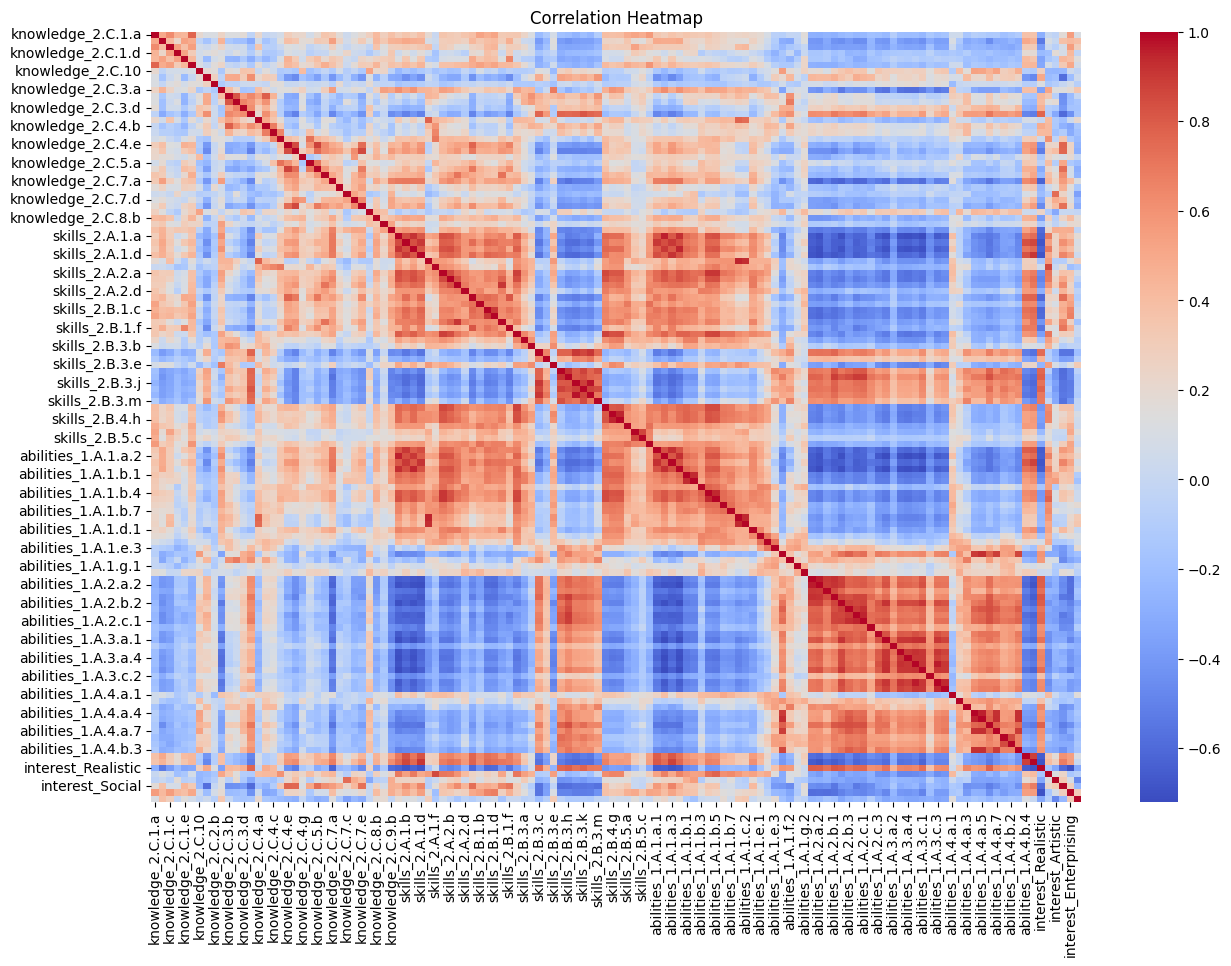

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

num_col = agg_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
corr = num_col.corr()  # Calculate correlations
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


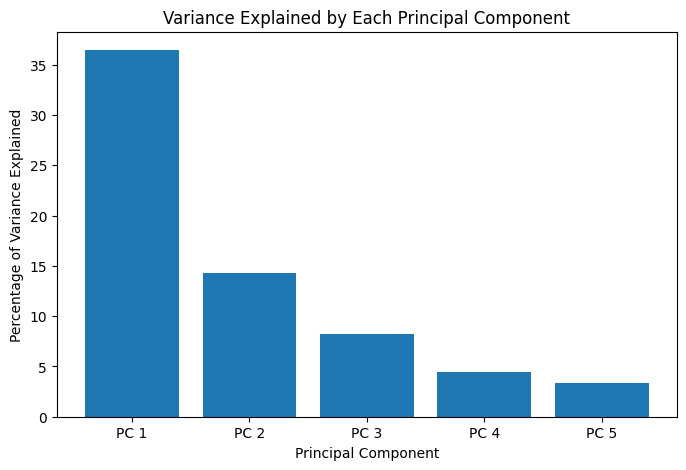

Cumulative Variance Explained by the first 5 components: 66.79%
Cumulative Variance Explained by the first 5 components: [36.463383 50.77415  58.98715  63.420044 66.7876  ]


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#normalization
features = agg_df.drop('onetsoc_code', axis=1)
scaler = StandardScaler()
scaled_f = scaler.fit_transform(features)

pca = PCA(n_components = 5)
pca_features = pca.fit_transform(scaled_f)
pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i}' for i in range(1, 6)])

pca_df['onetsoc_code'] = agg_df['onetsoc_code']
explained_var = pca.explained_variance_ratio_


# Plot explained variance by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), explained_var * 100, tick_label=[f'PC {i}' for i in range(1, 6)])
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Cumulative variance explained
cumulative_variance = explained_var.cumsum()
print(f'Cumulative Variance Explained by the first 5 components: {cumulative_variance[-1] * 100:.2f}%')

# Optionally save the transformed PCA data for future use
pca_df.to_csv('pca_transformed.csv', index=False)


cumulative_variance = explained_var.cumsum()
print(f'Cumulative Variance Explained by the first 5 components: {cumulative_variance[:5] * 100}')


total var is not high, which means they might have non-linear relation

In [31]:
# Get the PCA components (loadings)
loadings = pca.components_  # Shape: (n_components, n_features)

# Create a DataFrame for the loadings with column names
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)], index=features.columns)

# Display the loadings DataFrame
print(loadings_df)

# Optionally, get the top contributing columns for each PC
# Here we get the top 5 absolute values (most contributing features) for each PC
top_contributing_features = {}

for pc in loadings_df.columns:
    top_features = loadings_df[pc].abs().nlargest(5).index.tolist()  # Get the top 5 contributing columns
    top_contributing_features[pc] = top_features

# Print top contributing features for each PC
for pc, features in top_contributing_features.items():
    print(f'Top features for {pc}: {features}')


                             PC1       PC2       PC3       PC4       PC5
knowledge_2.C.1.a      -0.059381 -0.040899  0.064739  0.255822  0.060315
knowledge_2.C.1.b      -0.077349  0.022853  0.053136  0.110643 -0.103328
knowledge_2.C.1.c      -0.063441  0.004049 -0.023556  0.245218  0.000848
knowledge_2.C.1.d      -0.030439  0.033868  0.006380  0.204088  0.162647
knowledge_2.C.1.e      -0.043497  0.043370  0.127253  0.135546 -0.051278
...                          ...       ...       ...       ...       ...
interest_Investigative -0.084277 -0.105039 -0.063861 -0.201485 -0.008620
interest_Artistic      -0.050977  0.048663 -0.000621 -0.103226  0.329956
interest_Social        -0.091147  0.060844  0.170619 -0.119735  0.030136
interest_Enterprising  -0.084042  0.044789  0.044161  0.262046 -0.030439
interest_Conventional  -0.023944  0.022925 -0.121153  0.164179 -0.304853

[126 rows x 5 columns]
Top features for PC1: ['abilities_1.A.1.a.4', 'skills_2.A.1.a', 'skills_2.A.1.b', 'skills_2.A.1.c', 

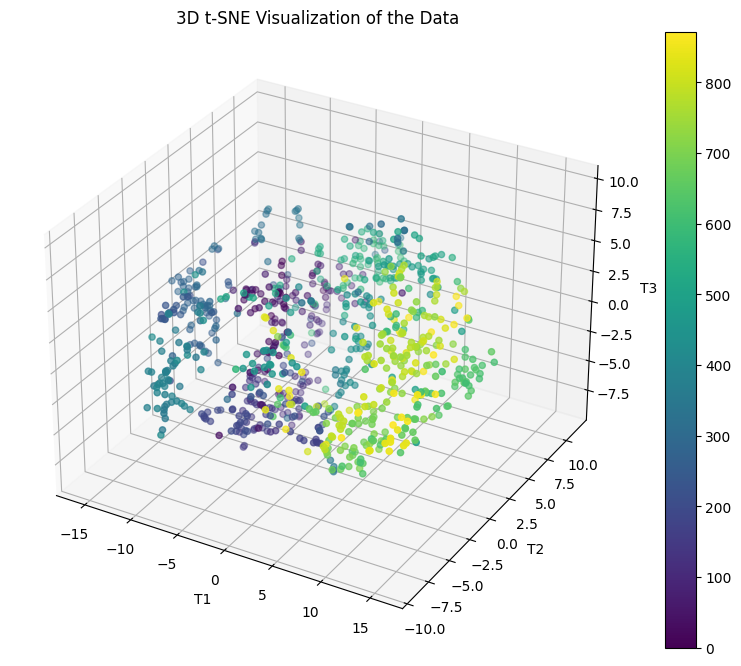

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Encode the onetsoc_code as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(agg_df['onetsoc_code'])

# Initialize t-SNE with 3 components for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)

# Fit and transform the scaled data
tsne_r = tsne.fit_transform(scaled_f)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_r, columns=['T1', 'T2', 'T3'])

# Add back the encoded onetsoc_code column for labeling the points
tsne_df['onetsoc_code'] = encoded_labels

# Plot the t-SNE result in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot, using the numeric labels for coloring
scatter = ax.scatter(tsne_df['T1'], tsne_df['T2'], tsne_df['T3'], c=tsne_df['onetsoc_code'], cmap='viridis')

# Add labels
ax.set_xlabel('T1')
ax.set_ylabel('T2')
ax.set_zlabel('T3')
plt.title('3D t-SNE Visualization of the Data')

# Add a color bar for better understanding of categories
fig.colorbar(scatter)

plt.show()



a:\UNI\website\Interest-seeker-Service\.interest\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


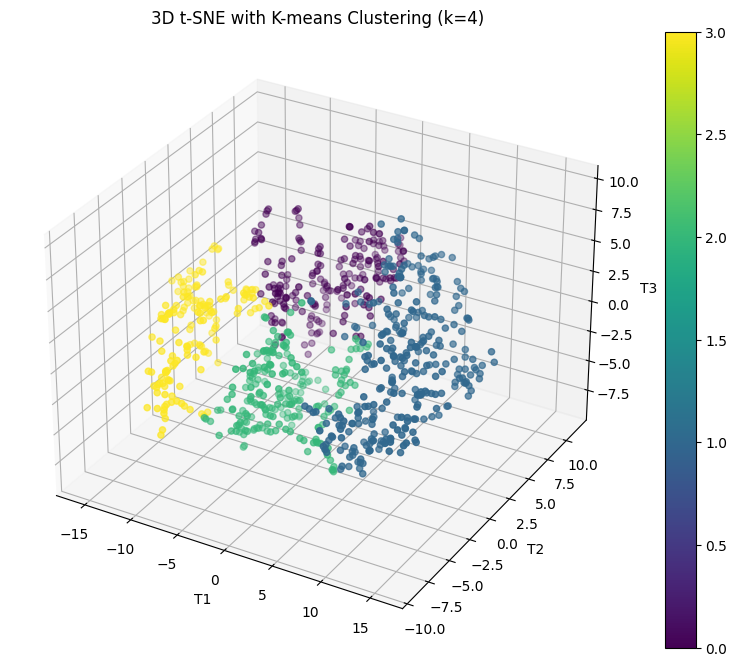

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Step 1: Apply K-means to the t-SNE results
# Assuming 'tsne_df' contains the t-SNE results ('T1', 'T2', 'T3')

# Set the number of clusters (experiment with different k values, e.g., 3, 4, 5)
k = 4  # You can adjust this to try different numbers of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tsne_df[['T1', 'T2', 'T3']])

# Add the K-means cluster labels to the DataFrame
tsne_df['cluster'] = kmeans.labels_

# Step 2: Visualize the K-means clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot, using the cluster labels for coloring
scatter = ax.scatter(tsne_df['T1'], tsne_df['T2'], tsne_df['T3'], c=tsne_df['cluster'], cmap='viridis')

# Add labels
ax.set_xlabel('T1')
ax.set_ylabel('T2')
ax.set_zlabel('T3')
plt.title(f'3D t-SNE with K-means Clustering (k={k})')

# Add a color bar for clusters
fig.colorbar(scatter)

plt.show()


AttributeError: 'list' object has no attribute 'columns'

# Scaling 